<font size=5.5><b> Задача мэтчинга товаров </b></font>

**Заказчик работы (исследования):** Один из крупнейших маркетплейсов страны. <br>
**Исходные данные:** Имеются базовая, обучающая и валидационная выборки, содержащие анонимизированный набор информации о товарах - в виде векторов признаков заданной длины.<br>
**Задача:** разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base, оценить качество алгоритма по метрике accuracy@5.<br>

## Загрузка и ознакомление с данными из датасетов

### Импорт библиотек и загрузка датафреймов

In [1]:
# импортируем требуемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import faiss

from sklearn.preprocessing import StandardScaler

import phik
from phik.report import plot_correlation_matrix

/Users/antonprokhorov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%time
# загрузим данные из файлов   
df_base = pd.read_csv('/Users/eternallife/Desktop/мэтчинг/base.csv', index_col=0) # данные базового датафрейма
df_train = pd.read_csv('/Users/eternallife/Desktop/мэтчинг/train.csv', index_col=0) # данные обучающего датафрейма
df_test = pd.read_csv('/Users/eternallife/Desktop/мэтчинг/validation.csv', index_col=0) # данные тестового датафрейма
y_test = pd.read_csv('/Users/eternallife/Desktop/мэтчинг/validation_answer.csv', index_col=0) # данные тестового целевого признака
print('local')

local
CPU times: user 28.3 s, sys: 2.88 s, total: 31.2 s
Wall time: 31.3 s


### Обзор исходных датафреймов

Выполним предварительный обзор исходных датафреймов - посмотрим на данные в загруженных исходных датафреймах.<br>
Для проведения обзора загруженных данных исходных датафреймов создадим функцию `df_review_function`, которая будет выводить следующую основную информацию о признаках, содержащихся в датафреймах:
- заданное количество первых строк датафрейма;
- краткую информацию о типах данных признаков и наличии пропущенных значений;
- некоторые статистические сведения о признаках датафрейма.

In [3]:
# установим вывод всех столбцов датафрейма
pd.set_option('display.max_columns', None)

In [4]:
def df_review_function(df, n_head_lines=5):
    """ Функция для предварительного обзора загруженных данных
        входные параметры функции:
        df - датафрейм для анализа
        n_head_lines - количество выводимых строк датафрейма (от начала) """
    
    # выведем первые head_lines строк датафрейма
    print('Первые строки датафрейма:')
    display(df.head(n_head_lines)); print('\n')
    
    # выведем основную информацию о датафрейме
    print('Краткая информация о датафрейме:', '\n');
    df.info(), print('\n') 
    print('Количество пропущенных значений признаков:', '\n');
    display(df.isna().sum()), print('\n')

    # выведем основную статистическую информацию о датафрейме
    print('Краткая статистическая информация о датафрейме:');
    display(df.describe(), print('\n'));

#### Обзор базового датасета

Выполним краткий обзор базового датасета с использованием разработанной функции `df_review_function`.

In [5]:
# обзор базового датафрейма
df_review_function(df_base)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

None

#### Обзор обучающего датасета

Выполним краткий обзор обучающего датасета с использованием разработанной функции `df_review_function`.

In [6]:
# обзор обучающего датафрейма
df_review_function(df_train)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20   

0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,-141.168584,-69.228444,-42.559541,6.506719,149.077582,-23.942253,-2.219093,-12.964439,-138.714610,-79.159795,-97.474574,1297.269578,-3.600685,55.908014,23.470181,742.788817,-64.970553,16.368072,-86.201170,152.098083,-13.659323,-144.506022,89.747894,-587.551768,36.468210,73.109595,-13.866967,-146.487267,-118.336458,-41.131969,-9.261504,4.139978,-104.928806,122.240784,-40.320211,59.051981,-84.054387,-140.787854,46.137851,-34.136875,29.462927,-22.343451,67.581086,-120.052756,88.193676,69.538752,-132.336967,14.452681,-120.301843,-315.282239,-66.378660,-130.672183,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,41.607785,51.258647,40.819544,37.593800,34.167843,13.024184,20.978943,55.210920,48.737245,0.775560,28.382144,375.123794,50.063680,35.617513,40.802653,191.052074,63.160650,4.828575,49.511818,10.392531,29.191689,35.816357,28.312124,273.294442,39.756311,20.008170,25.824911,10.383975,13.578397,19.868303,8.295381,5.922103,56.519443,48.109909,14.739497,31.088173,66.055063,59.851232,46.328286,59.325454,60.934591,54.991787,12.988132,55.920785,4.824051,12.339684,7.952113,49.234745,55.730177,210.657513,64.913422,9.408099,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,-330.570600,-352.405200,-214.742460,-145.860280,8.818390,-82.645004,-91.657020,-247.589280,-326.648740,-82.637184,-228.808260,136.873137,-211.971800,-87.323780,-122.584274,-61.803358,-338.562500,-6.629074,-285.668700,111.387250,-130.444920,-290.124000,-25.550720,-1044.135662,-119.903810,-11.926712,-124.560380,-193.918150,-166.078460,-123.062420,-43.063824,-18.980648,-324.943570,-67.540375,-63.102401,-64.789690,-327.322720,-365.060880,-129.879180,-280.371830,-250.337570,-236.148470,18.477040,-354.915700,66.068665,18.104557,-161.189320,-183.849880,-330.638180,-681.029305,-358.460450,-169.566400,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,-168.599020,-103.048815,-69.801705,-18.815189,126.369124,-32.379752,-16.455603,-49.612492,-171.661355,-79.656816,-115.407545,1248.126198,-37.047511,31.436791,-5.051067,813.770071,-106.860569,13.187895,-119.613590,145.143008,-32.812503,-168.535163,70.432237,-803.390708,9.505674,59.978086,-30.926924,-153.339210,-127.603408,

None

#### Обзор тестового датасета

Выполним краткий обзор тестового датасета с использованием разработанной ранее функции `df_review_function`.

In [7]:
# обзор тестового датафрейма
df_review_function(df_test)

Первые строки датафрейма:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255



Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20 

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64



Краткая статистическая информация о датафрейме:




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,-141.215384,-69.340237,-42.626768,6.272022,149.006081,-23.961728,-2.009594,-13.151269,-138.540600,-79.162680,-97.356361,1301.395163,-3.439855,56.097825,23.357262,741.156981,-64.986388,16.367853,-86.139332,152.078754,-13.476064,-144.568331,89.709031,-588.597042,36.554961,73.085400,-13.889099,-146.461500,-118.391474,-40.992214,-9.193917,4.157828,-104.775965,122.095524,-40.311826,59.123753,-83.620997,-141.003063,46.187760,-34.154328,29.404870,-22.542637,67.486142,-120.307717,88.174847,69.495540,-132.377437,14.411927,-120.381837,-316.401557,-66.614887,-130.653256,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,41.568432,51.483403,40.858017,37.845939,34.031665,13.014670,20.993654,55.340411,48.790143,0.777431,28.503558,371.543911,50.291410,35.599512,40.849607,193.199671,63.274623,4.845841,49.511970,10.406558,29.275776,35.911251,28.430405,273.788805,39.610961,20.044353,25.802824,10.389778,13.602543,19.845968,8.364438,5.910225,56.986969,48.130993,14.753263,31.126990,65.925312,59.595488,45.996789,59.611850,60.943297,55.140398,13.036243,56.107653,4.809309,12.324416,7.894675,49.387024,55.818220,211.131373,65.195278,9.426921,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,-321.544250,-363.493320,-204.299130,-144.100740,-14.816055,-78.597450,-86.843280,-272.565600,-329.860170,-82.665300,-231.376650,136.846377,-208.900850,-84.224530,-138.217000,-61.879841,-341.962220,-6.662937,-282.249330,110.357254,-150.154720,-281.123540,-24.076744,-1044.135662,-117.473145,-17.641396,-124.311615,-194.132930,-166.124450,-126.336075,-43.321170,-19.319794,-326.301300,-79.304720,-63.102401,-76.792040,-365.282530,-375.452200,-121.267914,-277.375920,-279.886380,-234.521500,12.404751,-381.609380,65.986030,17.301888,-162.872990,-156.581590,-329.700800,-681.038139,-339.966340,-168.735570,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,-168.562772,-103.338022,-70.147153,-19.089412,126.442184,-32.356516,-16.392179,-49.942476,-171.695623,-79.665475,-115.390365,1248.126198,-36.891637,31.741733,-5.265194,813.770071,-107.339855,13.182383,-119.527813,145.126130,-32.815898,-168.729353,70.166879,-803.390708,9.700724,59.971492,-30.786210,-153.332742,-127.66153

None

Убедимся, что в исходных датафреймах одни и те же столбцы (признаки), за исключением признака target в обучающем датасете.

In [8]:
print(set(df_train.columns) - set(df_base.columns))
print(set(df_train.columns) - set(df_test.columns))

{'Target'}
{'Target'}


#### Целевой признак для тестовой выборки

Выполним краткий обзор целевого признака для тестового датасета также с использованием разработанной ранее функции df_review_function.

In [9]:
# обзор целевого признака
df_review_function(y_test)

Первые строки датафрейма:


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base




Краткая информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Количество пропущенных значений признаков: 



Expected    0
dtype: int64



Краткая статистическая информация о датафрейме:




,Expected
count,100000
unique,91502
top,210304-base
freq,7


None

### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы:
- матрицы признаков представляют собой числа в формате с плавающей запятой (все признаки, кроме признака `Target` обучающей выборки - численные, `Target` формально можно отнести к категориальным);
- пропущенные значения признаков в датафреймах отсутствуют;
- нарушения стиля (прописные/строчные буквы, "верблюжий" регистр вместо "змеиного", пробелы, использование попеременно транслитерированных наименований с дословно переведенными) наблюдаются только в части наименований признаков - в целевом признаке `Target` обучающей выборки (наименование признака - с большой буквы), что не критично и не требует корректировок;
- признаки в датафреймах идентичны (за исключением целевого признака `Target`, который присутствует только в обучающем датафрейме), значения типов данных соответствуют ожидаемым.<br>

## Предобработка, EDA и повышение качества мэтчинга

### Предобработка и исследовательский анализ данных обучающего датасета

Выполним предобработку и EDA (признаков) обучающего датафрейма последовательно по каждому признаку и некоторую обработку - для всего датасета в целом.<br>
В ходе предобработки данных выполним проверку и корректировку/обработку (при необходимости) для каждого признака в части (с учетом типа признака - численный он или категориальный):
- наличия пропусков в значениях признака;
- наличия явных/неявных дубликатов в значениях признаков;
- наличия аномальных значений (выбросов) в признаках;
- возможного поиска некоторых других особенностей в данных (с визуализацией).

При проведении исследовательского анализа данных, а также далее, мы будем полагать, что целевым признаком у нас является `Target`.

Разделим исходный обучающий датасет на выборку признаков и целевой признак.

In [10]:
y_train = df_train['Target'] # целевой признак обучающей выборки
X_train = df_train.drop('Target', axis=1) # обучающая выборка

Поскольку согласно проведенному выше беглому обзору данных целочисленные признаки у нас выглядят как непрерывные, для проведения EDA создадим функцию `feature_study`, которая будет выводить следующую визуальную информацию о признаках:
- гистограмму признака;
- диаграмму размаха признака ("ящик с усами");
- среднее и медианное значения.

In [11]:
def feature_study(df, feature, bins_req, measure_unit):
    """ Функция для исследования признаков
        Входные параметры функции:
        df - датафрейм, содержащий признак для исследования
        feature - признак, подлежащий исследованию
        bins_req - количество "корзин" для разбиения значений признака
        measure_unit - единица измерения признака
        разрешена визуализация"""

    # построение гистограммы признака
    plt.subplot(1, 2, 1)
    df[feature].hist(bins=bins_req, figsize=(12, 4))
    str_title = 'Гистограмма признака ' + feature; plt.title(str_title);
    str_label = 'Значения/категория, ' + measure_unit; plt.xlabel(str_label);
    str_label = 'Количество, ' + measure_unit; plt.ylabel(str_label);

    plt.subplot(1, 2, 2)
    df.boxplot(column=[feature], figsize=(12, 4))
    str_title = 'Диаграмма размаха признака ' + feature; plt.title(str_title);
    str_label = 'Значения/категория, ' + measure_unit; plt.ylabel(str_label); plt.show()
    
    print(f'Среднее значение признака {feature}:', df[feature].mean(), measure_unit)
    print(f'Медианное значение признака {feature}:', df[feature].median(), measure_unit)

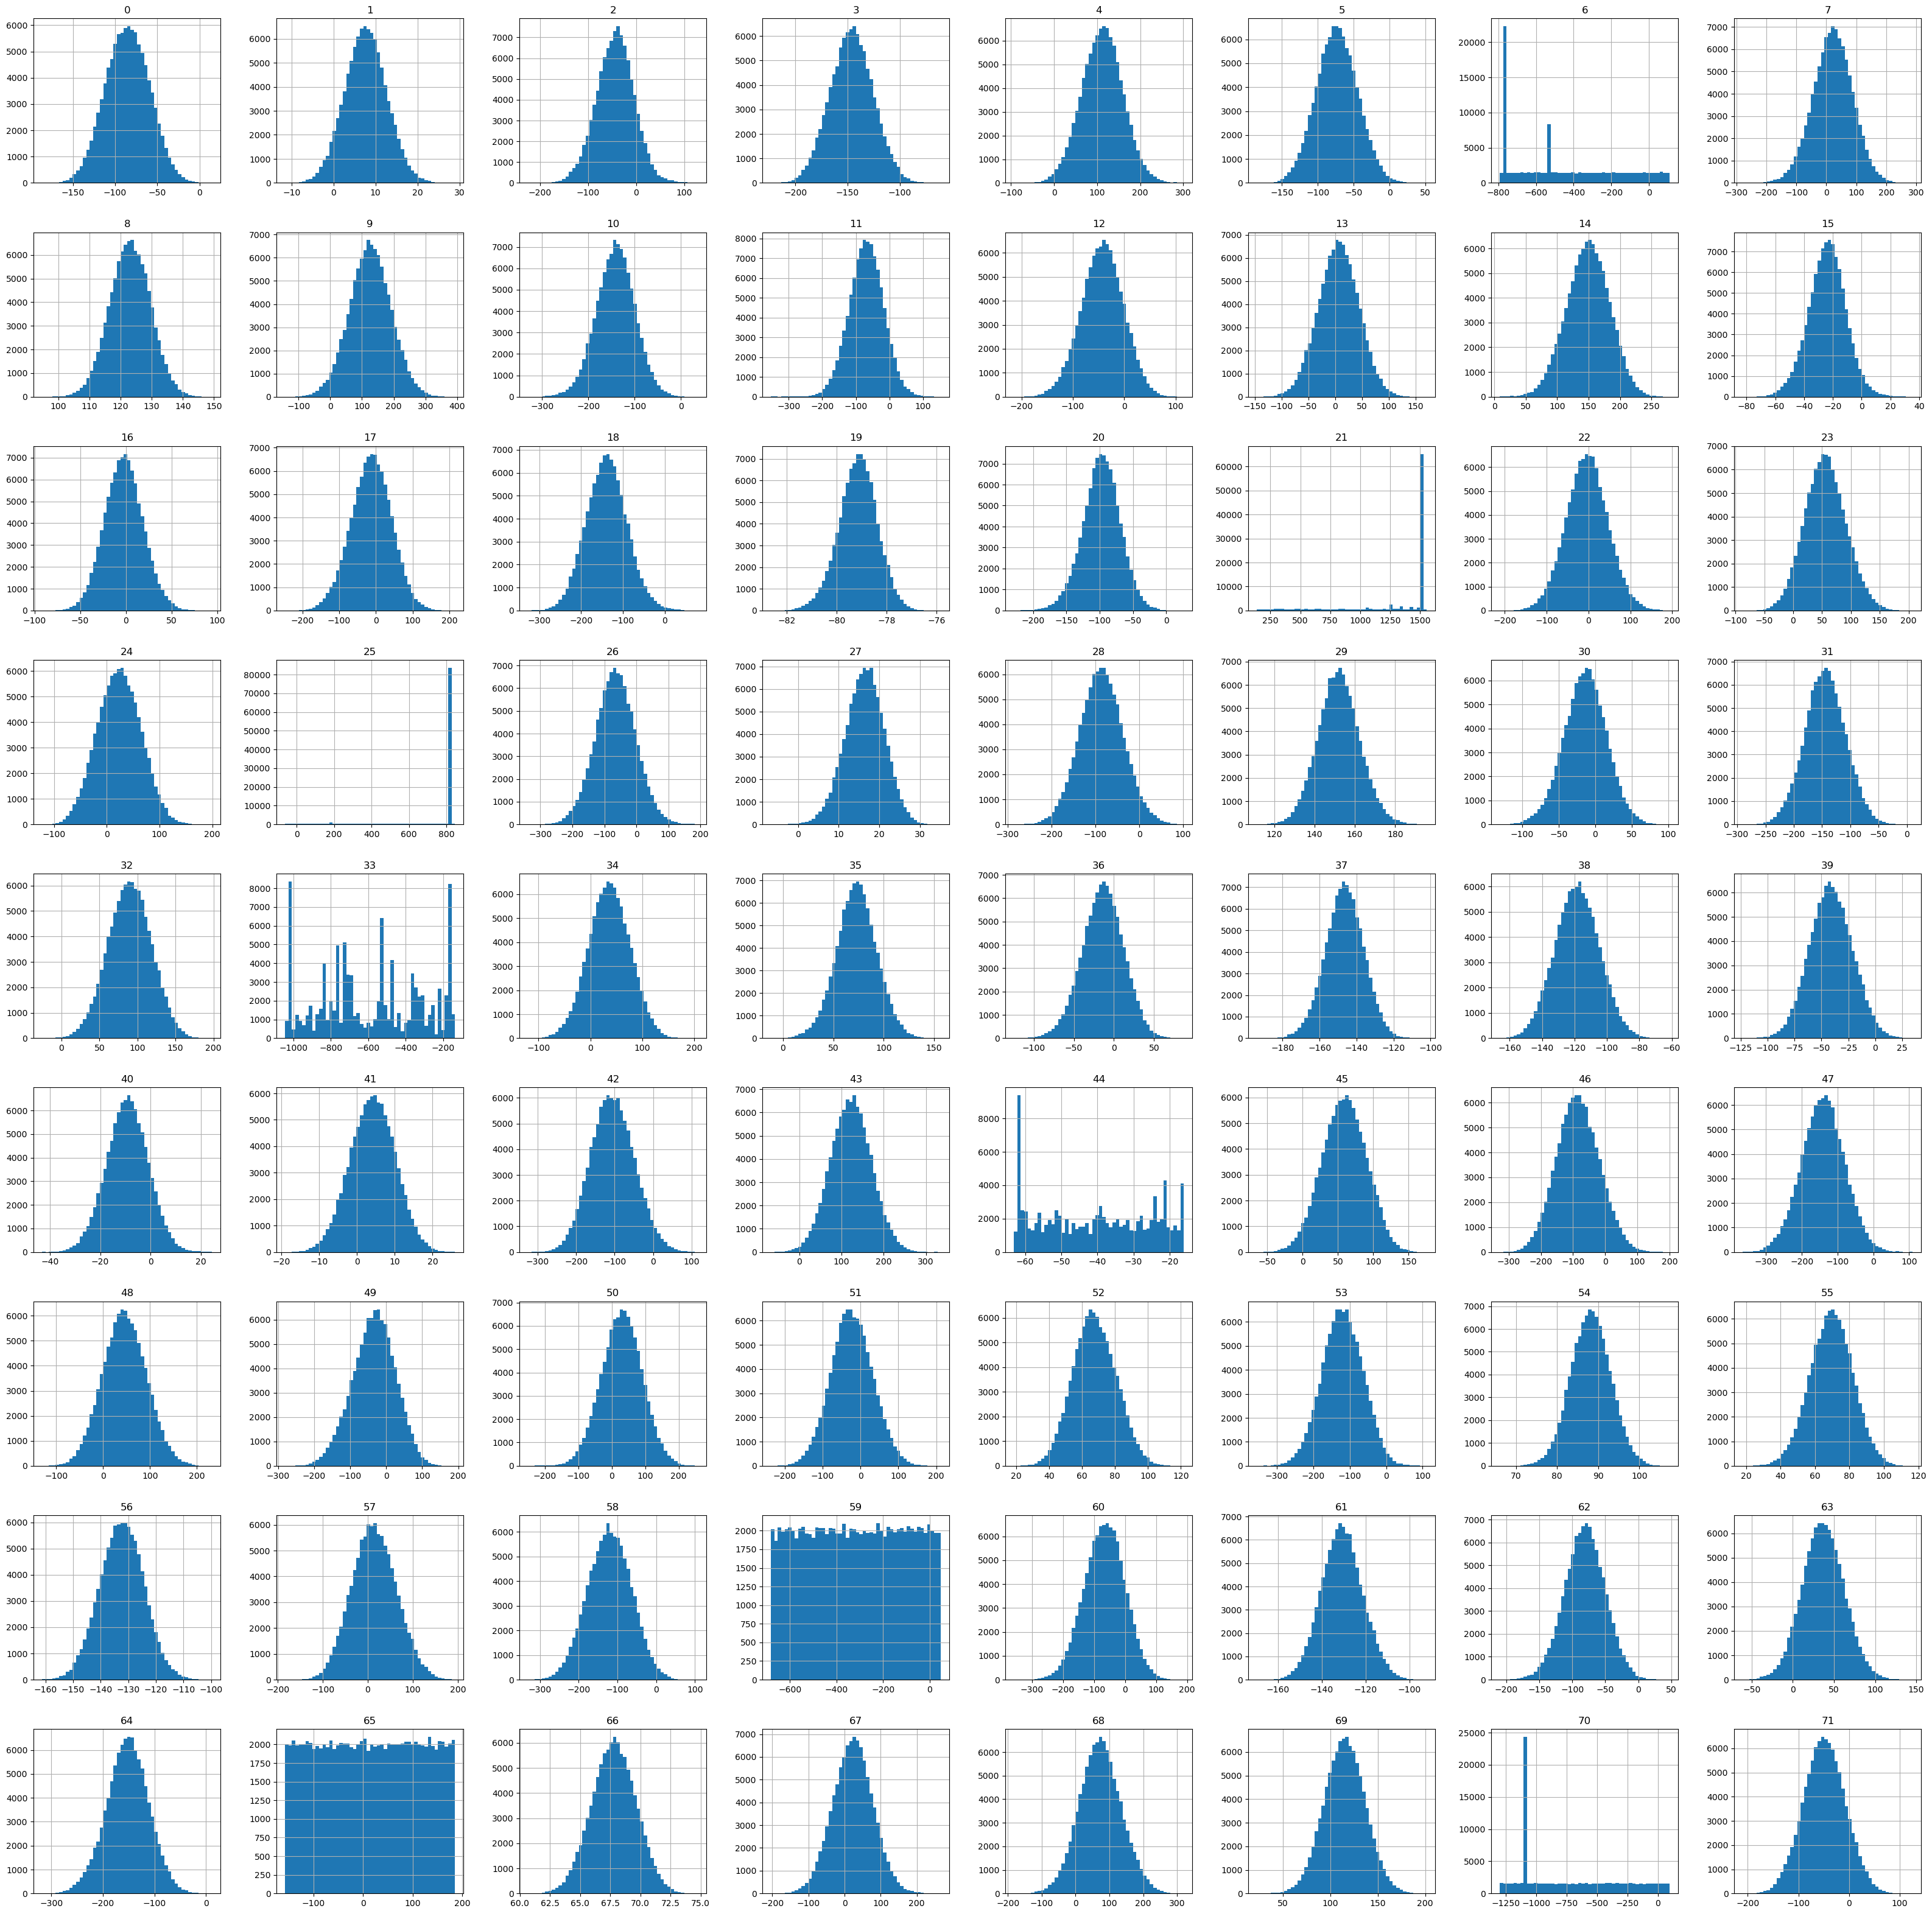

In [12]:
X_train.hist(bins=50, figsize=(40,40));

Краткий визуальный анализ полученных гистограмм признаков показывает, что большинство из них имеют нормальное или близкое к нормальному распределение, мат. ожидание, не равное нулю, и близкие по значению среднее арифметическое и медиану.
Также графики показывают, что есть некоторые признаки, имеющие отличное от нормального (и даже не близкое к нему) распределение (номера 6, 21, 25, 33, 44, 59, 65, 70)- полагаю их нужно отфильтровать либо удалить.

#### Признак `6`

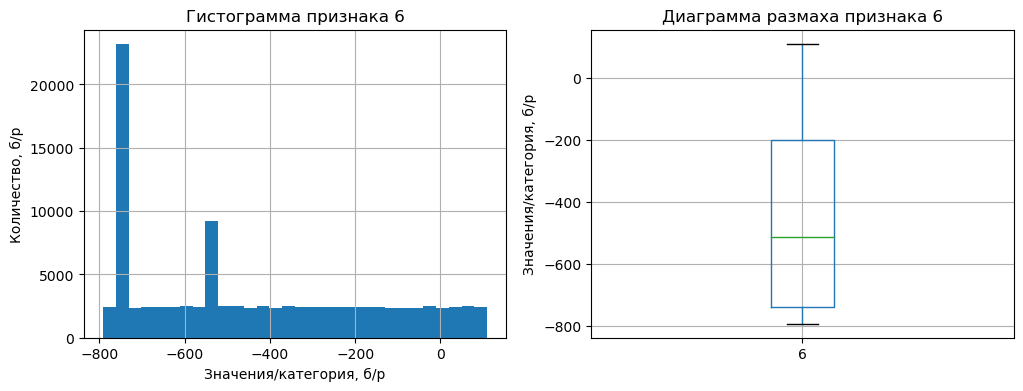

Среднее значение признака 6: -440.6151180373686 б/р
Медианное значение признака 6: -511.8377577524943 б/р


In [13]:
feature_study(df=X_train, feature='6', bins_req=30, measure_unit='б/р')

Отфильтруем датасет по значению признака, частота которого выделяется из общей картины распределения.

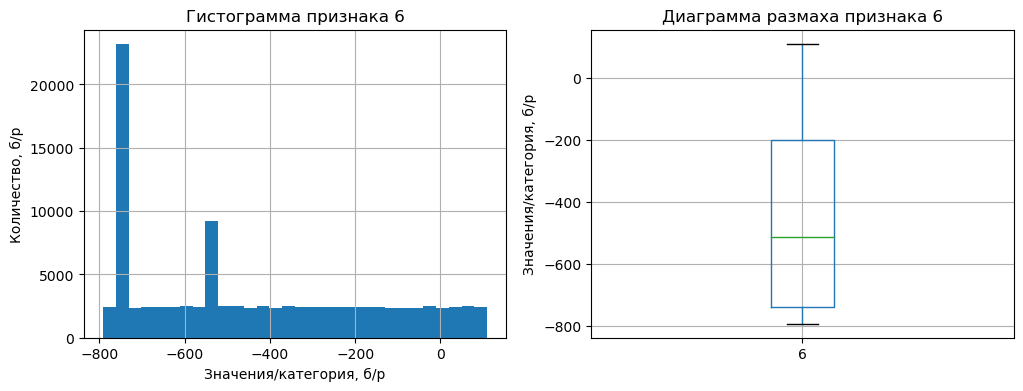

Среднее значение признака 6: -440.6151180373686 б/р
Медианное значение признака 6: -511.8377577524943 б/р


In [14]:
feature_study(df=X_train[X_train['6'] < 3000], feature='6', bins_req=30, measure_unit='б/р')

Это первый из признаков с не нормальным распределением. Этот признак не является константным и не является нулевым, его нельзя исключать из выборки.

#### Признак `21`

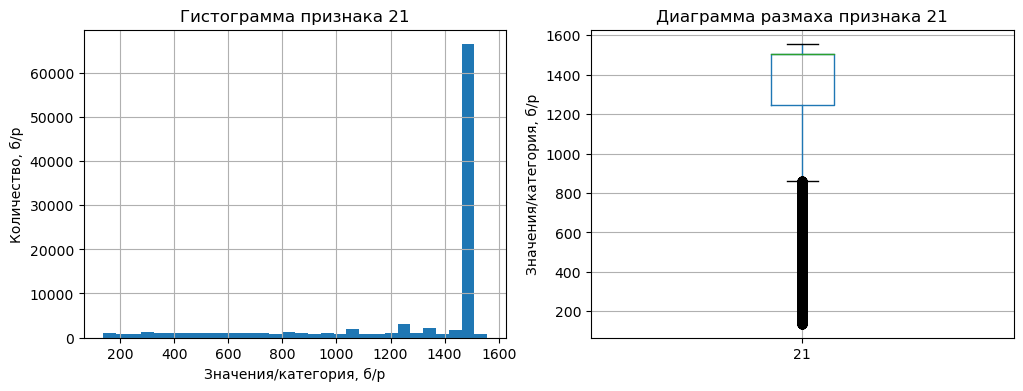

Среднее значение признака 21: 1297.2695779353028 б/р
Медианное значение признака 21: 1507.23127421948 б/р


In [15]:
feature_study(df=X_train, feature='21', bins_req=30, measure_unit='б/р')

Отфильтруем датасет по значению признака, частота которого выделяется из общей картины распределения и посмотрим, как изменится распределение в этом случае.

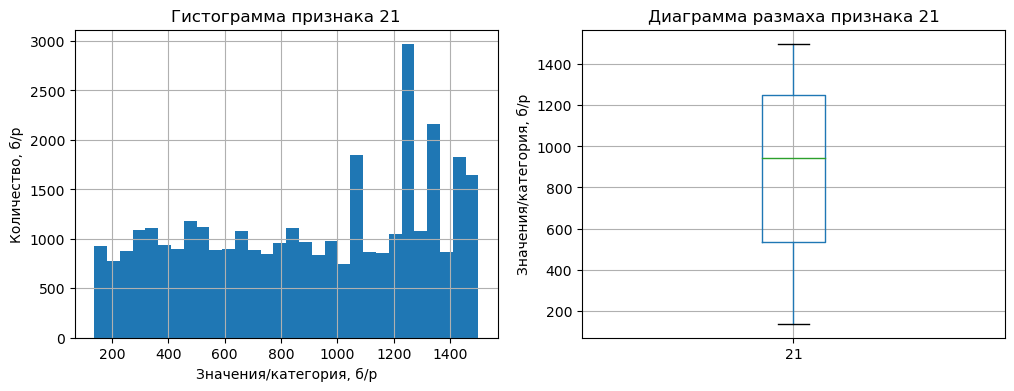

Среднее значение признака 21: 893.790867850835 б/р
Медианное значение признака 21: 941.5236307308212 б/р


In [16]:
feature_study(df=X_train[X_train['21'] < 1500], feature='21', bins_req=30, measure_unit='б/р')

Посмотрим, сколько объектов осталось в выборке после такой фильтрации.

In [17]:
X_train[X_train['21'] < 1500].shape

(34256, 72)

Мы не можем себе удалить более 2/3 данных из выборки просто так, тем более, что вид распределения особо не изменился. 

#### Признак `25`

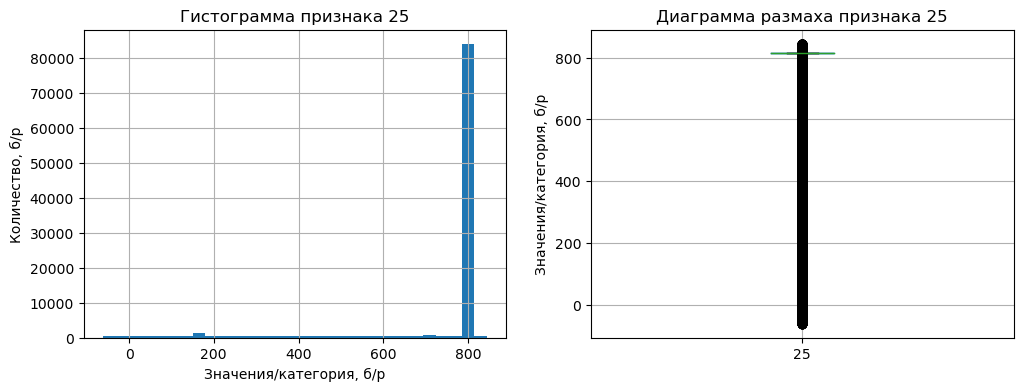

Среднее значение признака 25: 742.7888165806999 б/р
Медианное значение признака 25: 813.7700714289165 б/р


In [18]:
feature_study(df=X_train, feature='25', bins_req=30, measure_unit='б/р')

Отфильтруем датасет, посмотрим, сколько осталось объектов в выборке (аналогично предыдущему случаю).

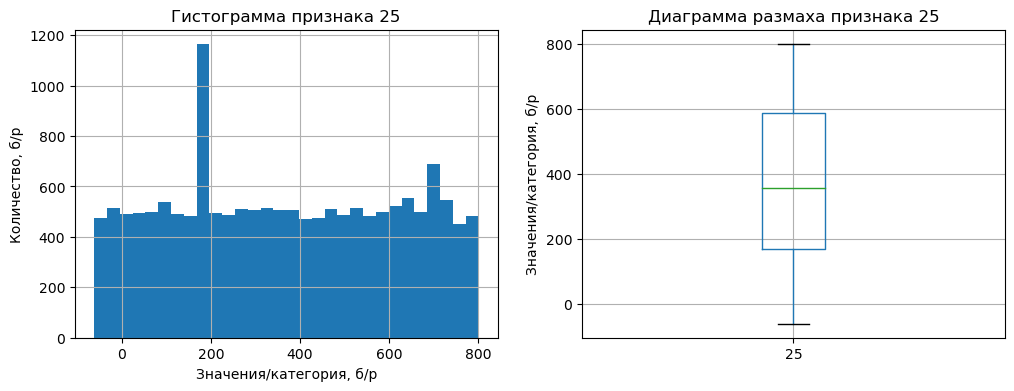

Среднее значение признака 25: 365.63187642705344 б/р
Медианное значение признака 25: 355.0226740532311 б/р


In [19]:
feature_study(df=X_train[X_train['25'] < 800], feature='25', bins_req=30, measure_unit='б/р')

Посмотрим, сколько объектов осталось в выборке после такой фильтрации.

In [20]:
X_train[X_train['25'] < 800].shape

(15855, 72)

#### Признак `33`

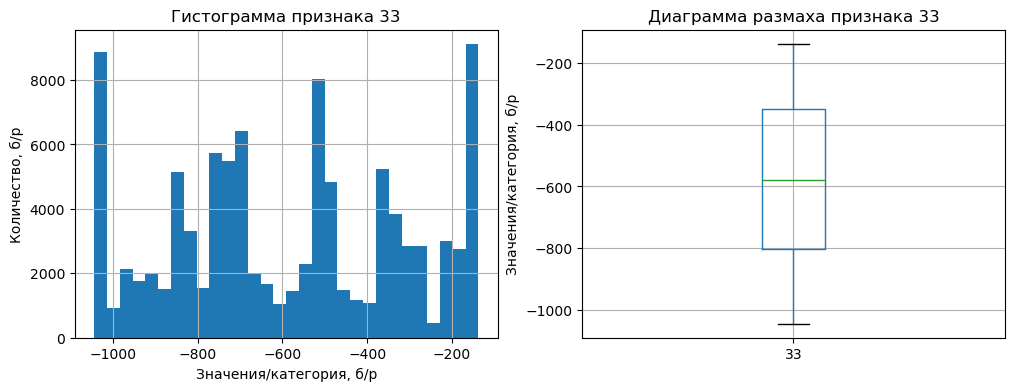

Среднее значение признака 33: -587.5517676084737 б/р
Медианное значение признака 33: -579.5903874885565 б/р


In [21]:
feature_study(df=X_train, feature='33', bins_req=30, measure_unit='б/р')

Признак не имеет ярко выраженного вида распределения, но в нем отсутствуют аномальные значения (согласно диаграмме размаха), среднее и медианные значения - близки, оставим признак.

#### Признак `44`

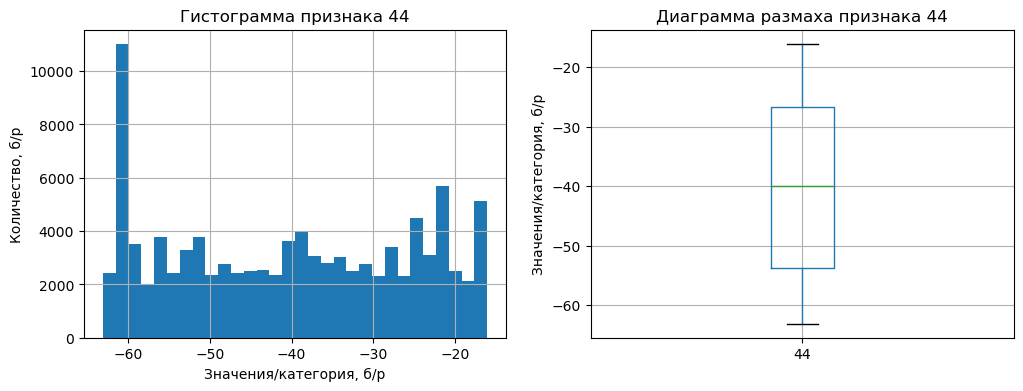

Среднее значение признака 44: -40.3202108380722 б/р
Медианное значение признака 44: -39.95456481840087 б/р


In [22]:
feature_study(df=X_train, feature='44', bins_req=30, measure_unit='б/р')

#### Признак `59`

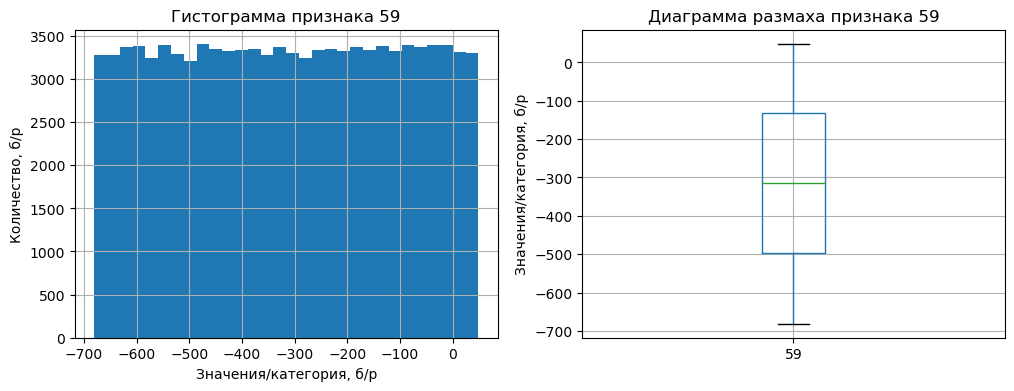

Среднее значение признака 59: -315.28223890201264 б/р
Медианное значение признака 59: -315.1772190530909 б/р


In [23]:
feature_study(df=X_train, feature='59', bins_req=30, measure_unit='б/р')

#### Признак `65`

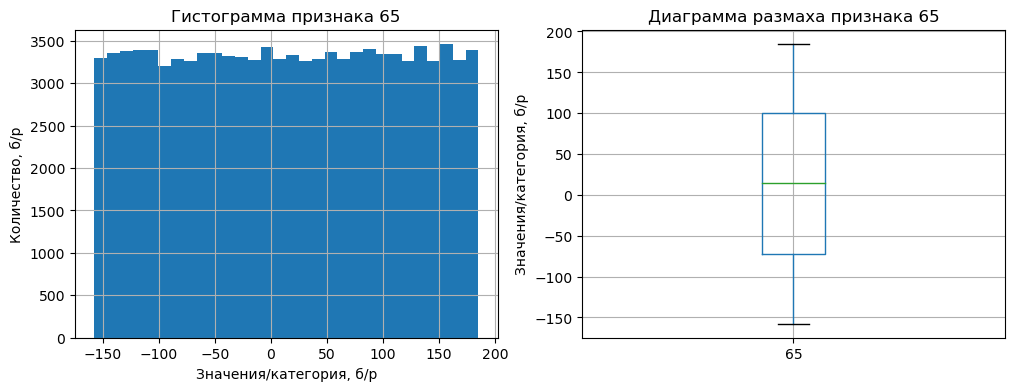

Среднее значение признака 65: 14.001695234429704 б/р
Медианное значение признака 65: 14.072662528028701 б/р


In [24]:
feature_study(df=X_train, feature='65', bins_req=30, measure_unit='б/р')

#### Признак `70`

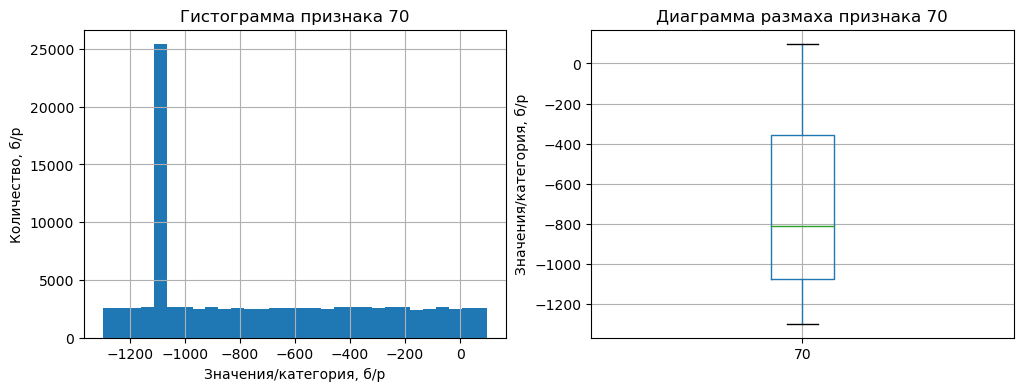

Среднее значение признака 70: -709.7615481263405 б/р
Медианное значение признака 70: -808.80169575276 б/р


In [25]:
feature_study(df=X_train, feature='70', bins_req=30, measure_unit='б/р')

По результатам краткого анализа признаков, выделяющихся из общей выборки (не имеющих нормального распределения), можно заключить, что пока удалить эти признаки из выборки мы не можем, никаких оснований у нас для этого нет. Попробуем выполнить масштабирование признаков, после чего проверим качество поиска с помощью FAISS.

### Разработка синтетических признаков

Проведем нормализацию, стандартизацию и масштабирование численных признаков.
Для начала определим столбцы выборок с численными признаками (исключая целевой признак).

In [26]:
num_cols = X_train.select_dtypes(include='number').columns # численные признаки

In [27]:
# проверка
num_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

#### Нормализация (масштабирование) численных признаков

In [28]:
# удалим X_train
#del X_train

In [29]:
%%time
# создадим объект - скэйлер
scaler = StandardScaler()
# обучим базовую выборку с отмасштабированными численными признаками
X_base = pd.DataFrame(scaler.fit_transform(df_base[num_cols]), index=df_base.index, columns=num_cols)

CPU times: user 3 s, sys: 1.41 s, total: 4.41 s
Wall time: 4.41 s


Трансформируем остальные выборки.

In [30]:
%%time
# X_train[num_cols] = scaler.transform(X_train[num_cols])
X_train = pd.DataFrame(scaler.transform(df_train[num_cols]), index=df_train.index, columns=num_cols)
X_test = pd.DataFrame(scaler.transform(df_test[num_cols]), index=df_test.index, columns=num_cols)

CPU times: user 80.3 ms, sys: 23.4 ms, total: 104 ms
Wall time: 102 ms


In [31]:
# проверим размерности
print(X_base.shape, X_train.shape, X_test.shape)

(2918139, 72) (100000, 72) (100000, 72)


### Решение задачи мэтчинга

Создадим индекс для базового датасета с помощью библиотеки faiss.

In [32]:
dims = X_base.shape[1] # размерность вектора признаков для каждого объекта
n_cells = 50 # количество кластеров (ячейки Воронова?)
quantizer = faiss.IndexFlatL2(dims) # квантователь 
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией

Проверим, что индекс не обучен и затем - обучим его.

In [33]:
print(idx_l2.is_trained)

False


In [34]:
idx_l2.train(np.ascontiguousarray(X_base.values[:50000, :]).astype('float32'))

In [35]:
print(idx_l2.is_trained)

True


Проверим, добавлены ли в индекс наши вектора признаков и добавим их.

In [36]:
print(idx_l2.ntotal)

0


In [37]:
%%time
idx_l2.add(np.ascontiguousarray(X_base.values).astype('float32'))

CPU times: user 9.16 s, sys: 3.13 s, total: 12.3 s
Wall time: 3.23 s


In [38]:
print(idx_l2.ntotal)

2918139


Создадим индекс из исходного базового датасета (его колонки "индекс") для удобства работы в дальнейшем.

In [39]:
%%time
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

CPU times: user 843 ms, sys: 161 ms, total: 1 s
Wall time: 565 ms


Выполним поиск ближайших соседей (повторим бейзлайн задачи мэтчинга), с учетом того, что нам необходимо найти 5 похожих товаров.

In [40]:
%%time
distx, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), 5)

CPU times: user 12min 11s, sys: 3.13 s, total: 12min 14s
Wall time: 1min 38s


Найдем значение требуемой метрики - accuracy@5. Для этого создадим функцию, которая на вход будет принимать вектор правильных ответов (значения целевого признака), вектор индексов ближайших соседей и базовый вектор индексов, ранее созданный, а на выходе - выдавать значение метрики accuracy.

In [41]:
def acc_5(targets, indices, base_indices):
    """ Функция для расчета значения метрики accuracy
        входные параметры функции:
        targets - вектор целевого признака
        indices - матрица индексов найденных ближайших соседей
        base_index - словарь базовых индексов """
    
    acc = 0 # начальное значение метрики
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in el])

    return 100 * acc / len(indices)

Найдем значение метрики (оценим качество алгоритма поиска), получающееся после масштабирования признаков датасетов.

In [42]:
%%time
print(acc_5(y_train, idx, base_index), '%')

54.981 %
CPU times: user 983 ms, sys: 33.1 ms, total: 1.02 s
Wall time: 543 ms


### Проверка данных на мультиколлинеарность

Найдем матрицу коэффициентов корреляции признаков обучающей выборки (не включая целевой признак по причинам, описанным ранее - размер матрицы с закодированным целевым признаком) с использованием готовых функций библиотеки phik.<br>
При этом, не будем выводить значения и визуализировать (строить тепловую карту по найденной матрице коэффициентов корреляции признаков обучающей выборки) матрицу коэффициентов корреляции - в силу ее объемности она поместится для отображения на экране. Нам же важно лишь максимальное и минимальное значения в этой матрице.

In [44]:
%%time
# матрица коэффициентов корреляции признаков обучающей выборки
correlation_matrix = X_train.phik_matrix();
# correlation_matrix.round(2)

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']


/Users/antonprokhorov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/antonprokhorov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/antonprokhorov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/antonprokhorov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (de

CPU times: user 1min 36s, sys: 6.67 s, total: 1min 43s
Wall time: 1min 54s


Найдем максимальное и минимальное значения коэффициентов корреляции.

In [45]:
correlation_matrix[correlation_matrix < 1.0].max().sort_values(ascending=False).head(1)

21    0.427656
dtype: float64

In [46]:
correlation_matrix.min().sort_values().head(1)

0    0.0
dtype: float64

Итак, максимальное значение коэффициента равно 0.4276 (при минимальном, равном 0.0). Это говорит о том, что между признаками матрицы обучения нет сильной линейной зависимости, а это значит, - мы не можем удалить какие-то признаки.

## Вывод

В ходе проведенной работы было выполнено следующее:
- краткие предобработка и исследовательский анализ признаков обучающей выборки:
    - анализ показал, что большинство признаков имеют нормальное распределение, но ряд признаков (под номерами 6, 21, 25, 33, 44, 59, 65 и 70) - имеют распределение, отличное от нормального;
    - признаки, имеющие не нормальное распределение, не были обработаны (не удалялись "аномальные" значения, не удалялись целиком признаки из выборок);
- нормализация (масштабирование/стандартизация) численных (а это - фактически все признаки из датасетов, кроме целевого признака) признаков с помощью стандартного инструмента StandardScaler;
- проверка данных (обучающей выборки) на мультиколлинеарность. Проверка показала, что максимальное (по модулю) значение коэффициента фи-корреляции равно 0.4276 - такая слабая линейная зависимость признаков обучающей выборки не позволяет нам сделать вывод о возможности удаления каких-либо признаков из выборки;
- проверено качество решения задачи поиска похожих товаров для отмасштабированных данных, к что уже является неплохим результатом (при прочих равных условиях).
